In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %reload_ext autoreload

In [3]:
from pathlib import Path
import matplotlib.pyplot as plt
import skimage.io as io
import numpy as np
import homography, rectification, filters, my_types, utils

# input files

In [4]:
DATA = Path("data")
OUTDIR = Path("output")

In [5]:
name  = "doll"
im1_name = DATA / (name + "1.jpg")
im2_name = DATA / (name + "2.jpg")

In [6]:
plane_name = DATA / (name + "_plane.pkl")

warp1_name = OUTDIR / (im1_name.stem + "_w.jpg")
warp2_name = OUTDIR / (im2_name.stem + "_w.jpg")

pts1_name = OUTDIR / (im1_name.stem + "_w.pkl")
pts2_name = OUTDIR / (im2_name.stem + "_w.pkl")

In [7]:
mosaic_name = OUTDIR / (name + "_mosaic.jpg")

# Pick Correspondences

In [8]:
im1 = utils.read_img(im1_name)
im2 = utils.read_img(im2_name)

In [9]:
try:
    %matplotlib inline
    im1_pts = utils.load_points(im1_name)
    im2_pts = utils.load_points(im2_name)
except:
    %matplotlib tk
    im1_pts = utils.pick_points(im1_name, 8)
    im2_pts = utils.pick_points(im2_name, 8)
    utils.save_points(im1_pts, im1_name)
    utils.save_points(im2_pts, im2_name)

In [10]:
im1_pts = im1_pts[:4]
im2_pts = im2_pts[:4]

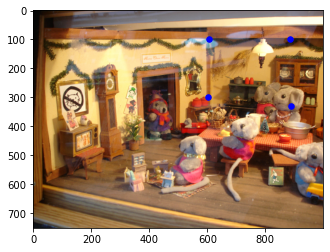

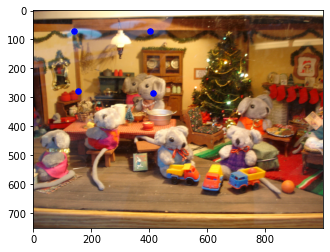

In [11]:
utils.plot_pts(im1, im1_pts)
utils.plot_pts(im2, im2_pts)

# Image Rectification

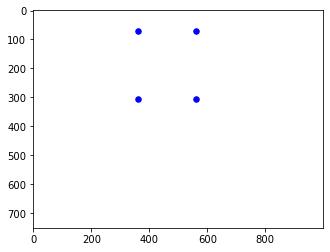

In [12]:
try:
    plane_pts = utils.load_points(plane_name)
except:
    pts = utils.pick_points(im1, 4)
    utils.save_points(plane_name)
    
canvas = np.ones_like(im1)
utils.plot_pts(canvas, plane_pts)

In [13]:
try:
    warp1 = utils.read_img(warp1_name)
    warp_pts1 = utils.load_points(pts1_name)

except:
    print("warping...")

    h_matrix1 = homography.homo_matrix(im1_pts, plane_pts)
    warp1, shift_pts1 = homography.forward_warp(im1, h_matrix1)
    warp_pts1 = homography.warp_pts(im1_pts, h_matrix1, shift_pts1)
    
    plt.imsave(warp1_name, warp1)
    utils.save_points(warp_pts1, pts1_name)

In [14]:
try:
    warp2 = utils.read_img(warp2_name)
    warp_pts2 = utils.load_points(pts2_name)

except:
    print("warping...")
    
    h_matrix2 = homography.homo_matrix(im2_pts, plane_pts)
    warp2, shift_pts2= homography.forward_warp(im2, h_matrix2)
    warp_pts2 = homography.warp_pts(im2_pts, h_matrix2, shift_pts2)

    plt.imsave(warp2_name, warp2)
    utils.save_points(warp_pts2, pts2_name)

In [15]:
warp_pts1

array([[727., 168.],
       [727., 404.],
       [927., 404.],
       [927., 168.]])

In [16]:
warp_pts2

array([[159.,  82.],
       [159., 318.],
       [359., 318.],
       [359.,  82.]])

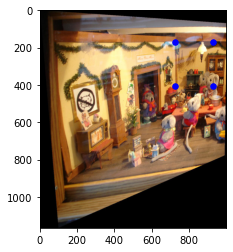

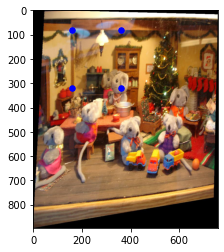

In [17]:
utils.plot_pts(warp1, warp_pts1)
utils.plot_pts(warp2, warp_pts2)

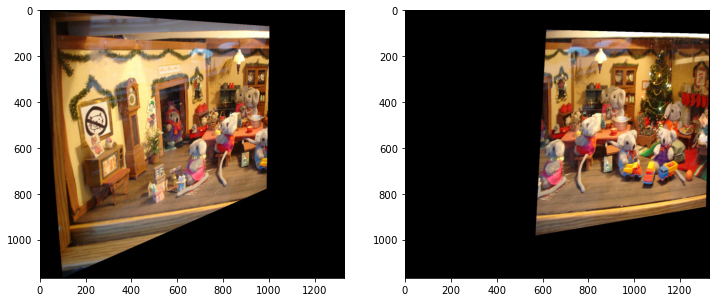

In [18]:
aligned1, aligned2 = rectification.align(warp1, warp2, warp_pts1, warp_pts2)
utils.show_two(aligned1, aligned2)

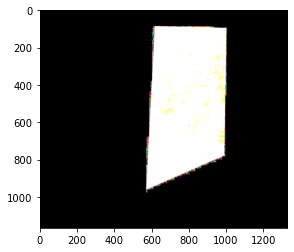

In [19]:
overlap = rectification.overlap(aligned1, aligned2)
plt.imshow(overlap)

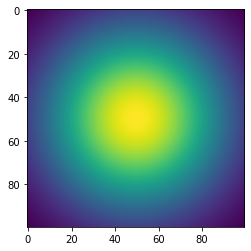

In [20]:
g = filters.gaussian_filter(kernel_size=100, sigma=30)
plt.imshow(g)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


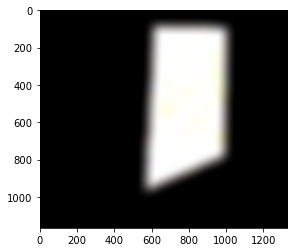

In [21]:
mask = filters.gauss_blur(overlap, kernel_size=100, sigma=30)
plt.imshow(mask)

In [22]:
blended = rectification.alpha_blend(aligned1, aligned2, mask)
blended.shape

(1167, 1328, 3)

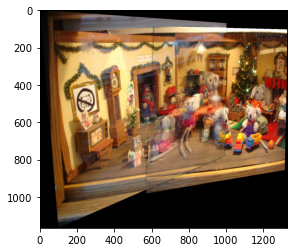

In [23]:
plt.imshow(blended)
plt.imsave(mosaic_name, blended)